# Data exploration and preprocessing

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error
import pickle
from utility import *
import sklearn.model_selection as model_selection
import sklearn.linear_model as linear_model
from collections import defaultdict
import seaborn as sns
from featureGen import newFeatures
from rebalance import *

%load_ext autoreload
%autoreload 2

In [2]:
#load and augment the data based on symmetry between A and B
raw = pd.read_csv("training_data.csv")
splitVec = splitStabilityVector(raw.stabilityVec)
xin, yin = augment(raw, splitVec)
xindummy = pd.get_dummies(xin)

#perform 80:20 train test split
#save xtrain as data with element predictors as dummary variables
#save xtrain_noelem as data without element predictors
train, test = model_selection.train_test_split(np.arange(xin.shape[0]), test_size = 0.2)
print("train count: ", len(train), " test count: ", len(test))
xtrainWOdummy = xin.iloc[train]
xtrain = xindummy.iloc[train]
xtest = xindummy.iloc[test]
xtrain_noelem = xin.drop(["formulaA","formulaB"], axis = 1)
xtrain_noelem = xtrain_noelem.iloc[train]
xtest_noelem = xin.drop(["formulaA","formulaB"], axis = 1)
xtest_noelem = xtest_noelem.iloc[test]
ytrain = yin[train]
ytest = yin[test]


#save the data
pSave(xtrain,"xtrain")
pSave(xtest, "xtest.csv")

pSave(xtrain_noelem, "xtrain_noelem.csv")
pSave(xtest_noelem, "xtest_noelem.csv")

pSave(ytrain, o"ytrain.csv", "wb")
pSave(ytest, "ytest.csv", "wb")

train count:  4115  test count:  1029


## Feature Visualization

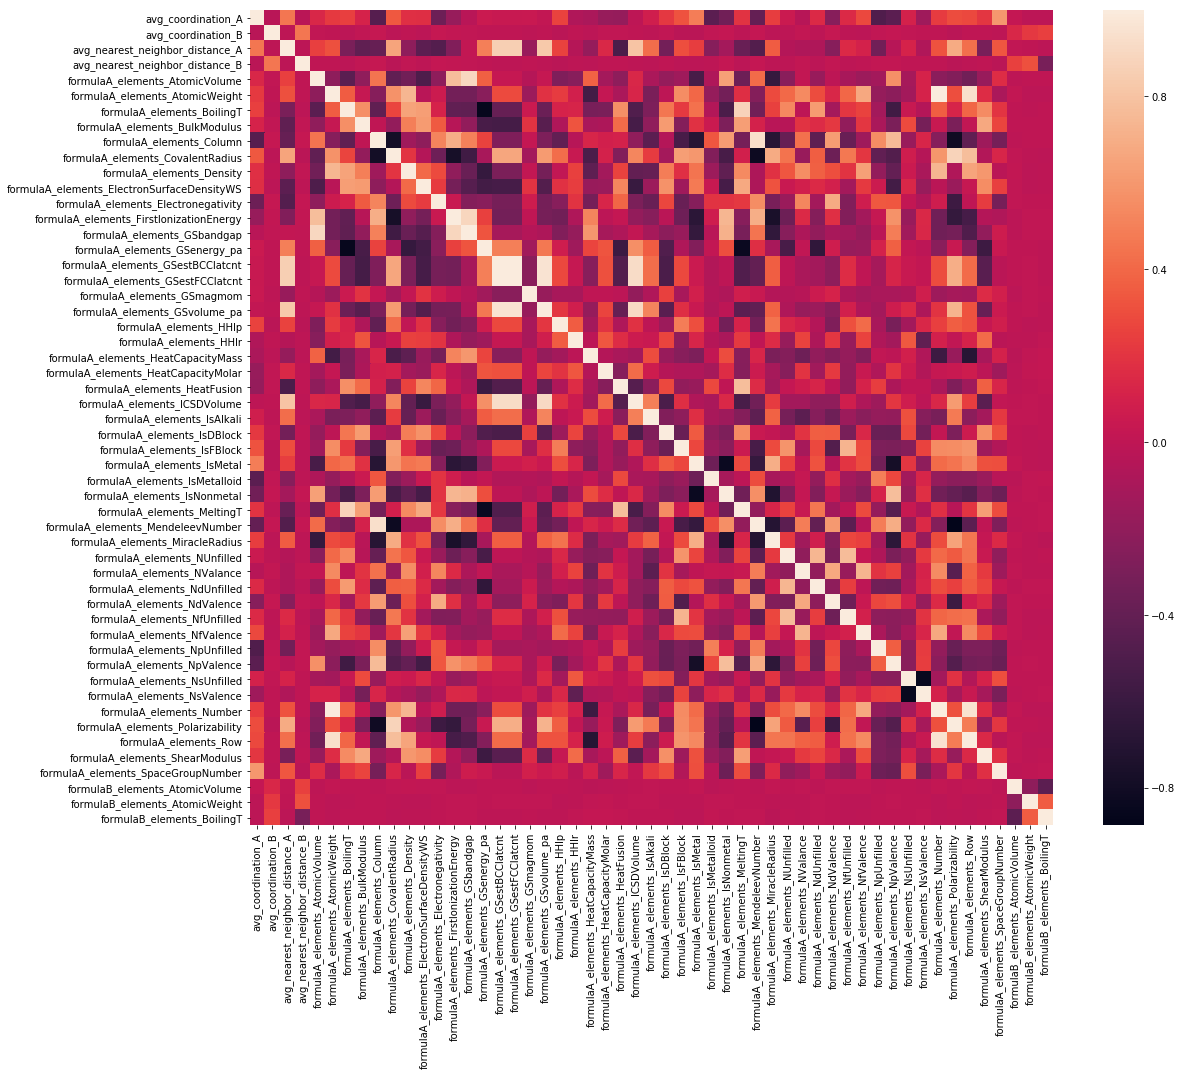

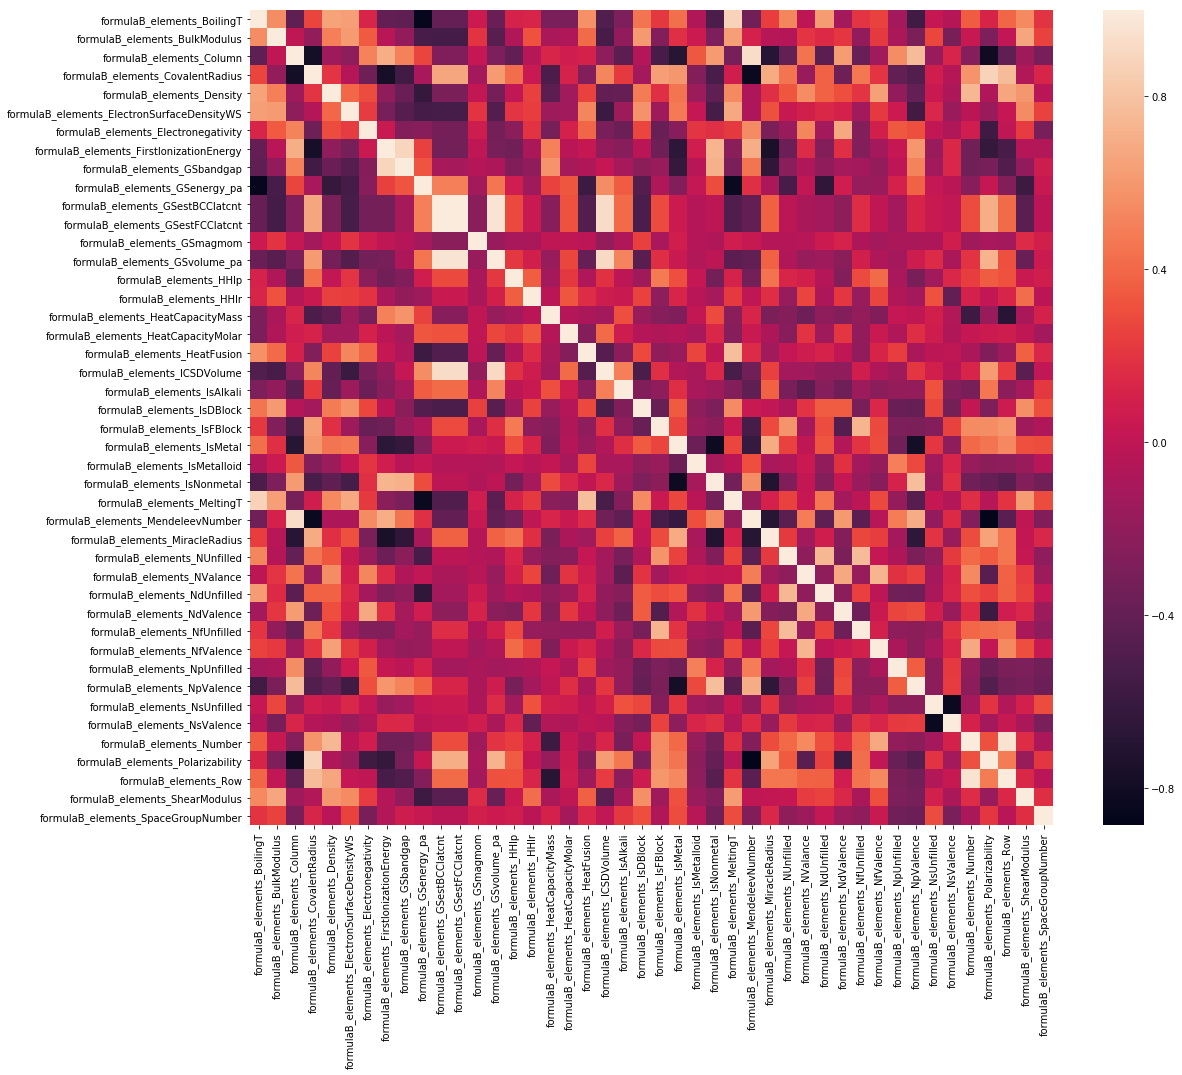

In [3]:
plt.figure(figsize=(18,15))
sns.heatmap(xtrain_noelem.loc[:,:"formulaB_elements_BoilingT"].corr())

plt.show()

plt.figure(figsize=(18,15))
sns.heatmap(xtrain_noelem.loc[:,"formulaB_elements_BoilingT":].corr())

plt.show()

lattice constant is correlated with GSvolum and ICSD volume

fcc and bcc lattice constants correlated

bandgap and ionization energy are correlated

element number and row are correlated

radius in inverse with column

unfilled valence s electrons is anticorrelated with filled valence electrons and likewise for others

These make sense based on chemical intuition




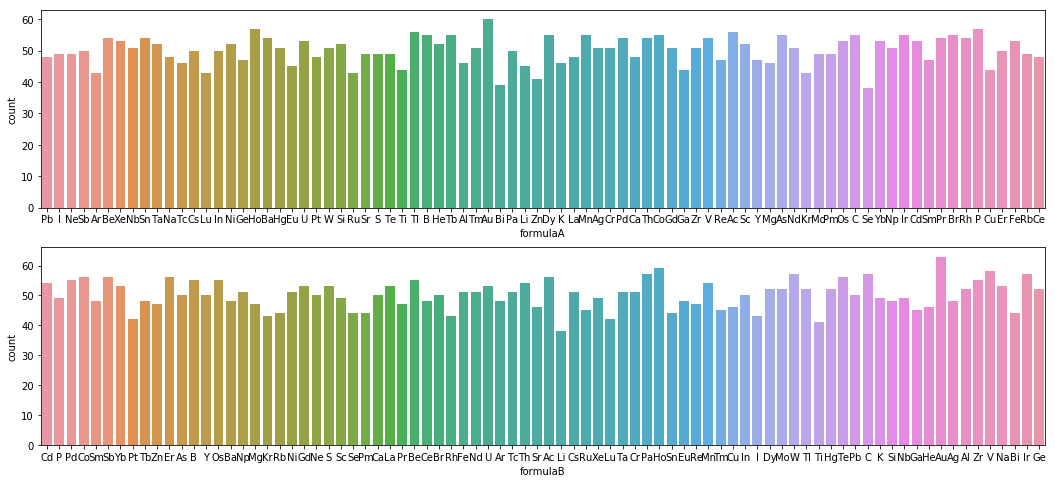

In [4]:
plt.figure(figsize=(18,8))
plt.subplot(211)
sns.countplot(x="formulaA", data=xtrainWOdummy)
plt.subplot(212)
sns.countplot(x="formulaB", data=xtrainWOdummy)
plt.show()

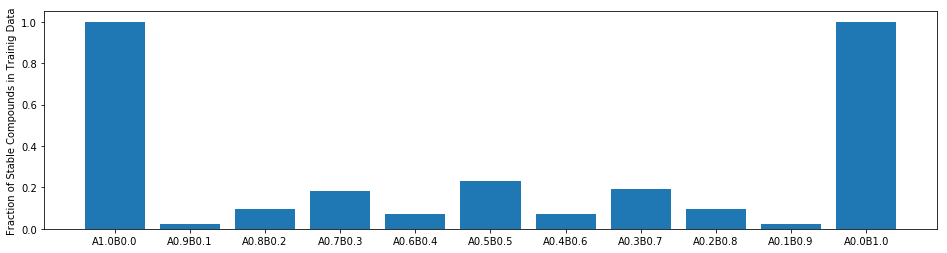

In [44]:
plt.figure(figsize=(16,4))
plt.bar(np.arange(ytrain.shape[1]),np.mean(ytrain, axis = 0))

plt.ylabel('Fraction of Stable Compounds in Trainig Data')
plt.xticks(np.arange(ytrain.shape[1]), ["A" + str(np.round(1-i/10, decimals = 1)) + "B" + str(i/10) for i in range(11) ])
plt.show()

All pure elements are stable in the training data. Therefore the model for pure elements is the trival one. As expected, the data is symmetric for AxB(1-x) as the data was augmented based on A B symmetry.

For binary compounds, the majority are unstable.

## Feature generation and data balancing

We can augment the feature set to include new features about the relative values
in particular the different between parameters, the average, and the fraction of valence electrons based on:
https://journals.aps.org/prb/supplemental/10.1103/PhysRevB.89.094104/Ultra-Fast_Materials_Screening-prb-SI.pdf

In [41]:
xtrain2 = newFeatures(xtrain)
pSave(xtrain2, "xtrain2")
xtrain_noelem2 = newFeatures(xtrain_noelem)
pSave(xtrain_noelem2, "xtrain_noelem2")
xtest_noelem2 = newFeatures(xtest_noelem)
pSave(xtest_noelem2, "xtest_noelem2")
xtest2 = newFeatures(xtest)
pSave(xtest2, "xtest2")

A large fraction of the vectors have mostly zero entries. To avoid the model being biased towards entries that are zero, we can resample the dataset

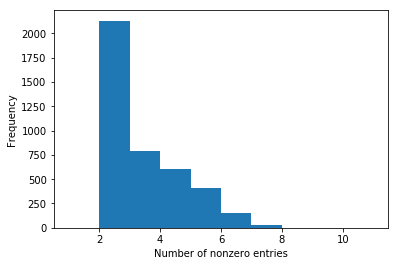

In [7]:
plt.hist(np.sum(ytrain, axis = 1), bins = np.arange(1,12))
plt.xlabel("Number of nonzero entries")
plt.ylabel("Frequency")
plt.show()

In [8]:
zero, nonzero = splitClasses(ytrain)

In [9]:
#want to make a train data set per x. will have different sizes
#want equal x and y

zero, nonzero = splitClasses(ytrain)
#scramble the zeros add equal amount to the nonzeros. shuffle occurs inplace
for x in zero:
    np.random.shuffle(x)
    
#add equal amounts of the scrambled to the normal
balancedIndices = [nonzero[i] + zero[i][0:len(nonzero[i])] for i in range(len(nonzero))]


balancedtrainIndices = [[] for x in range(ytrain.shape[1])] 
balancedvalIndices = [[] for x in range(ytrain.shape[1])]  

for i in range(ytrain.shape[1]):
    balancedtrainIndices[i], balancedvalIndices[i] = model_selection.train_test_split(balancedIndices[i], test_size = 0.25)
#reproduces the splits between 0 and 1 in true data
#unbalancedvalidation
print("calculating averages of stability for each index in the balanced training data")
print("index overall average   val average   train average")
for i in range(ytrain.shape[1]):
    print(i, "\t",np.mean(ytrain[balancedIndices[i], i]).round(decimals = 2), "\t\t",
          np.mean(ytrain[balancedtrainIndices[i], i]).round(decimals = 2), "\t\t",np.mean(ytrain[balancedvalIndices[i], i]).round(decimals = 2))
print("")

#append data to to unbalanced data to create a train/val split of the original data 
#where the original train/val split for the balanced data is preserved
#adds 3/4 of unused data to train and 1/4 to val
unbalancedtrainIndices = [balancedtrainIndices[i].copy() for i in range(ytrain.shape[1])]
unbalancedvalIndices = [balancedvalIndices[i].copy() for i in range(ytrain.shape[1])]
for i in range(ytrain.shape[1]):
    unbalancedtrainIndices[i] += zero[i][len(nonzero[i]):int(len(nonzero[i]) + (len(zero[i]) - len(nonzero[i]))*.75)]
    unbalancedvalIndices[i] += zero[i][int(len(nonzero[i]) + (len(zero[i]) - len(nonzero[i]))*.75):]
    
print("calculating averages of stability for each index in the balanced training data")
print("ytrain overall average   val average   train average")
for i in range(ytrain.shape[1]):
    print(i, "\t",np.mean(ytrain[:, i]).round(decimals = 2), "\t\t",
          np.mean(ytrain[unbalancedvalIndices[i], i]).round(decimals = 2), "\t\t",np.mean(ytrain[unbalancedtrainIndices[i], i]).round(decimals = 2))


calculating averages of stability for each index in the balanced training data
index overall average   val average   train average
0 	 1.0 		 1.0 		 1.0
1 	 0.5 		 0.5 		 0.5
2 	 0.5 		 0.5 		 0.49
3 	 0.5 		 0.49 		 0.52
4 	 0.5 		 0.5 		 0.49
5 	 0.5 		 0.5 		 0.49
6 	 0.5 		 0.5 		 0.49
7 	 0.5 		 0.51 		 0.48
8 	 0.5 		 0.5 		 0.51
9 	 0.5 		 0.47 		 0.59
10 	 1.0 		 1.0 		 1.0

calculating averages of stability for each index in the balanced training data
ytrain overall average   val average   train average
0 	 1.0 		 1.0 		 1.0
1 	 0.02 		 0.02 		 0.02
2 	 0.09 		 0.09 		 0.09
3 	 0.18 		 0.19 		 0.18
4 	 0.07 		 0.07 		 0.07
5 	 0.23 		 0.23 		 0.23
6 	 0.07 		 0.07 		 0.07
7 	 0.19 		 0.18 		 0.19
8 	 0.09 		 0.09 		 0.09
9 	 0.02 		 0.03 		 0.02
10 	 1.0 		 1.0 		 1.0


In [10]:
#making train, validation, and truth data structures to contain the balanced data and saving the data
ytrainBalanced = [ytrain[balancedtrainIndices[i] , i] for i in range(ytrain.shape[1])]
yvalBalanced = [ytrain[balancedvalIndices[i] , i] for i in range(ytrain.shape[1])]
pSave(ytrainBalanced, "ytrainBalanced")
pSave(yvalBalanced, "yvalBalanced")

xtrainBalanced = [xtrain.iloc[balancedtrainIndices[i]] for i in range(ytrain.shape[1])]
xvalBalanced = [xtrain.iloc[balancedvalIndices[i]] for i in range(ytrain.shape[1])]
pSave(xtrainBalanced, "xtrainBalanced")
pSave(xvalBalanced, "xvalBalanced")

pSave(balancedtrainIndices, "trainIndices")
pSave(balancedvalIndices, "valIndices")
pSave(unbalancedtrainIndices, "unbaltrainIndices")
pSave(unbalancedvalIndices, "unbalvalIndices")

We can also setup training data that excludes stability vectors that are the 0 case to train models with multidimensional output and have a better balance between classes.

In [35]:
trivial, nonTrivial = splitTrivial(ytrain)
print("Observations in ytrain without trivial stability vectors: ", len(nonTrivial))
display(pd.DataFrame({"initial ytrain average values": np.mean(ytrain,axis = 0), 
             "new ytrain average values":np.mean(ytrain[nonTrivial],axis = 0)}))


Observations in ytrain without trivial stability vectors:  1985


,initial ytrain average values,new ytrain average values
0,1.000000,1.000000
1,0.021385,0.044332
2,0.093317,0.193451
3,0.182746,0.378841
4,0.070474,0.146096
5,0.229648,0.476071
6,0.069502,0.144081
7,0.189793,0.393451
8,0.093317,0.193451
9,0.021385,0.044332


In [45]:
#Splitting to a train and validation set, and saving
trivialtrain, trivialval = model_selection.train_test_split(trivial, test_size = 0.25, random_state = 5)
nonTrivialtrain, nonTrivialval = model_selection.train_test_split(nonTrivial, test_size = 0.25, random_state = 5)
pSave(trivialtrain, "trivialtrain")
pSave(trivialval, "trivialval")
pSave(nonTrivialtrain, "nontrivialtrain")
pSave(nonTrivialval, "nontrivialval")

In [46]:
np.sum(ytrain[nonTrivialtrain], axis = 0)

array([1488.,   65.,  294.,  576.,  220.,  722.,  211.,  592.,  289.,
         64., 1488.])

## Loading and preprocessing the test data set

In [6]:
rawtest = pd.read_csv("test_data.csv")

In [9]:
test_noelem = rawtest.drop(["formulaA","formulaB"], axis = 1)

In [11]:
test_noelem2 = newFeatures(test_noelem)
test_noelem2.shape

(749, 114)

In [12]:
pSave(test_noelem2, "test_noelem2")